In [34]:
import time

import cv2
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor

from yolort.utils import Visualizer
from yolort.v5 import load_yolov5_model

from PIL import Image
import numpy as np

In [35]:
# configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = False if str(device) == "cpu" else True
weights_blood_det_th = "/home/ajvalenc/Projects/spectronix/detection_models/blood_fever/weights/torchscript/traced_blood_det_th-{}.pt".format(device).replace(":0","")
weights_blood_det_ir = "/home/ajvalenc/Projects/spectronix/detection_models/blood_fever/weights/torchscript/traced_blood_det_ir-{}.pt".format(device).replace(":0","")

In [42]:
# check model labels
weights_blood_det_ir_torch = "/home/ajvalenc/Projects/spectronix/detection_models/blood_fever/weights/pytorch/Blood_Detection_Yolov5_ir.pt"
model_yolov5_ir = load_yolov5_model(weights_blood_det_ir_torch)
model_yolov5_ir = model_yolov5_ir.to(device)
model_yolov5_ir = model_yolov5_ir.eval()

print("IR model labels", model_yolov5_ir.names)

IR model labels {0: 'Blood_Background', 1: 'Blood_Skin'}


In [4]:
print("Loading detection model...")
model_blood_det_th = torch.jit.load(weights_blood_det_th)
model_blood_det_ir = torch.jit.load(weights_blood_det_ir)
print("Detection models loaded successfully")

Loading detection model...
Detection models loaded successfully


In [48]:
# input data and transform (using opdirectory_th{"/home/ajvalenc/Datasets/spectronix/thermal/failure/"};
filename_ir = "/home/ajvalenc/Datasets/spectronix/ir/blood/8bit/s11_thermal_cloth_01_000028493212_ir/0370.png"
filename_th = "/home/ajvalenc/Datasets/spectronix/thermal/blood/8bit/s11_thermal_cloth_01_MicroCalibir_M0000334/0370.png"
img_th = cv2.imread(filename_th, cv2.IMREAD_ANYDEPTH)
img_ir = cv2.imread(filename_ir, cv2.IMREAD_ANYDEPTH)

In [22]:
def sixteen_bits2eight_bits(pixel):
    # Pseudo colouring the 16 bit images
    pixel = (pixel - np.min(pixel)) / (30100-np.min(pixel))
    pixel = np.rint(pixel * 255)
    return pixel.astype("uint8")

In [50]:
# conversion
#img_prc_th = sixteen_bits2eight_bits(img_th)
img_prc_th = img_th
img_prc_th = cv2.cvtColor(img_prc_th, cv2.COLOR_GRAY2BGR)
ts_img_th = torch.as_tensor(img_prc_th.astype("float32").transpose(2,0,1)).to(device)
ts_img_th /= 255.
ts_img_th = ts_img_th.unsqueeze(0)

#img_prc_ir = sixteen_bits2eight_bits(img_ir)
img_prc_ir = img_ir
img_prc_ir = cv2.cvtColor(img_prc_ir, cv2.COLOR_GRAY2BGR)
ts_img_ir = torch.as_tensor(img_prc_ir.astype("float32").transpose(2,0,1)).to(device)
ts_img_ir /= 255.
ts_img_ir = ts_img_ir.unsqueeze(0)

In [51]:
# dry run
for i in range(3):
    model_blood_det_th(ts_img_th)
    model_blood_det_ir(ts_img_ir)

In [52]:
with torch.no_grad(): #ensures autograd is off
    out_bdet_th = model_blood_det_th(ts_img_th)
    out_bdet_ir = model_blood_det_ir(ts_img_ir)

In [53]:
print("Output bdet th:", out_bdet_th[1][0])
print("Output bdet ir:", out_bdet_ir[1][0])

Output bdet th: {'scores': tensor([0.84911, 0.76996, 0.69114, 0.65841, 0.64669, 0.62335, 0.61081, 0.54088, 0.53318], device='cuda:0'), 'labels': tensor([0, 3, 1, 2, 0, 0, 0, 0, 1], device='cuda:0'), 'boxes': tensor([[445.20148, 321.32816, 500.36664, 446.42953],
        [191.75500, 253.52171, 220.96909, 278.67007],
        [146.17117, 283.27325, 171.01242, 304.86279],
        [226.95694, 395.07416, 243.58124, 413.77692],
        [485.32562, 175.18794, 512.02667, 199.56377],
        [501.54819, 249.25148, 511.21585, 263.03064],
        [546.48810, 286.96530, 554.98883, 296.49332],
        [497.01990, 229.88287, 506.92377, 241.15433],
        [173.06354, 270.87888, 183.44650, 279.16080]], device='cuda:0')}
Output bdet ir: {'scores': tensor([0.74669], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'boxes': tensor([[193.99673, 258.13202, 220.18829, 279.59796]], device='cuda:0')}


In [54]:
def visualize(image, normalize=False):

    if normalize:
        image = cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 

    # rescale (16-bit image only) see method 2 https://answers.opencv.org/question/207313/conversion-16bit-image-to-8-bit-image/
    if (image.dtype) == np.uint16:
        image = image / 257
        image = image.astype(np.uint8)

    #cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

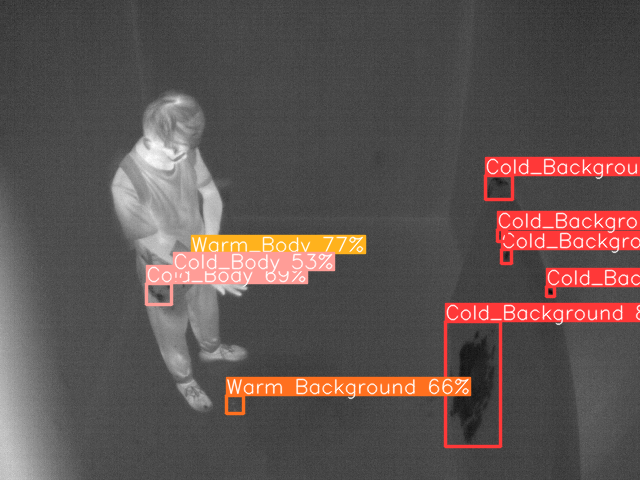

In [55]:
# verify results
img_raw_th = cv2.imread(filename_th, cv2.IMREAD_ANYDEPTH) #original
v = Visualizer(visualize(img_raw_th, True), ["Cold_Background", "Cold_Body", "Warm Background", "Warm_Body", "Warm_Dripping"])
v.draw_instance_predictions(out_bdet_th[1][0])
v.imshow(scale=1.0)

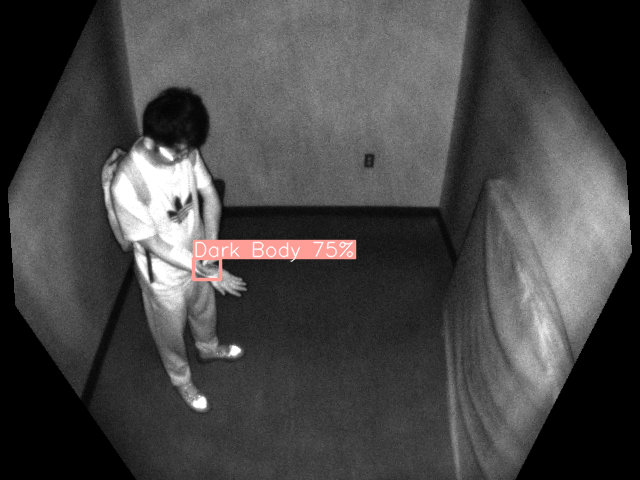

In [56]:
# verify results
img_raw_ir = cv2.imread(filename_ir, cv2.IMREAD_ANYDEPTH) #original
#v = Visualizer(visualize(img_prc_th, False), ["Cold_Background", "Cold_Body", "WB", "Warm_Body", "Warm_Dripping"])
v = Visualizer(visualize(img_prc_ir, True), ["Dark_Background", "Dark_Body"])
v.draw_instance_predictions(out_bdet_ir[1][0])
v.imshow(scale=1.0)